<a href="https://colab.research.google.com/github/Jojocko/Feedback-users-supply-chain/blob/main/M%C3%A9thodes%203%20%26%204%3A%20classification%20par%20similarit%C3%A9%20et%20DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets NLP/dataset_supplychain.csv')

In [3]:
df = df.drop(['client', 'langage', 'reponse'], axis=1)
df.rename(columns={'Sentiment': 'sentiment', 'Commentaire': 'commentaire'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'__label__POSITIVE': 'positif', '__label__NEGATIVE': 'negatif', '__label__NEUTRAL': 'neutre'})
df['date'] = df['date'].fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

df.head()

,commentaire,star,date,source,company,cleaned_words,cleaned_lemma,sentiment,year
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,TrustPilot,Amazon,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...,negatif,2023
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,TrustPilot,Amazon,amazon politique pire contrairement ...,amazon politique pire contrairement ...,negatif,2023
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,TrustPilot,Amazon,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...,positif,2023
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,TrustPilot,Amazon,preleve commande jamais reçu service cl...,prelev commande jamais recevoir service...,negatif,2023
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,TrustPilot,Amazon,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...,negatif,2023


In [4]:
supervised_df = pd.read_csv('/content/drive/My Drive/Datasets NLP/supervised_dataset.csv')
supervised_df.head()

,human checked ?,Unnamed: 1,review,chatgpt_label,hallucinated labels count,star,date,company,month,prompt tokens,completion tokens
0,True,95902.0,Commande ordinateur N° 170713152921GXY1er bémo...,"[""Problème de livraison""]",0.0,1.0,2017-08-02,CDiscount,2017-08,646.0,8.0
1,True,103756.0,Je ne pensais que le site Fnac était un site d...,"[""Problème avec le produit""]",0.0,1.0,2019-12-08,Fnac,2019-12,475.0,8.0
2,True,94681.0,"Jusqu'à présent fidèle à Cdiscount, je peux vo...","[""Problème avec le produit""]",0.0,1.0,2018-05-06,CDiscount,2018-05,551.0,8.0
3,False,58723.0,Central vapeur acheté en octobre tombée en pan...,"[""Problème de livraison""]",0.0,1.0,2020-06-27,CDiscount,2020-06,584.0,8.0
4,False,2114.0,Je met 1 étoile.. je peux pas mettre moins bre...,"[""Problème de livraison""]",0.0,1.0,2021-12-02,Amazon,2021-12,522.0,8.0


In [5]:
supervised_df = supervised_df.drop(['prompt tokens','completion tokens', 'hallucinated labels count', 'human checked ?', 'Unnamed: 1', 'star'],axis=1)
supervised_df = supervised_df.dropna(axis=0)
supervised_df['chatgpt_label'] = supervised_df['chatgpt_label'].str.replace("[\[\]'\"\"]", '', regex=True)

supervised_df.head()

,review,chatgpt_label,date,company,month
0,Commande ordinateur N° 170713152921GXY1er bémo...,Problème de livraison,2017-08-02,CDiscount,2017-08
1,Je ne pensais que le site Fnac était un site d...,Problème avec le produit,2019-12-08,Fnac,2019-12
2,"Jusqu'à présent fidèle à Cdiscount, je peux vo...",Problème avec le produit,2018-05-06,CDiscount,2018-05
3,Central vapeur acheté en octobre tombée en pan...,Problème de livraison,2020-06-27,CDiscount,2020-06
4,Je met 1 étoile.. je peux pas mettre moins bre...,Problème de livraison,2021-12-02,Amazon,2021-12


chatgpt_label
Problème de livraison           58
Problème avec le produit        47
Problème de remboursement       33
Problème dabonnement            23
Problème sur le site            15
Problème de rupture de stock    12
                                 6
Problème de retour               6
Name: count, dtype: int64


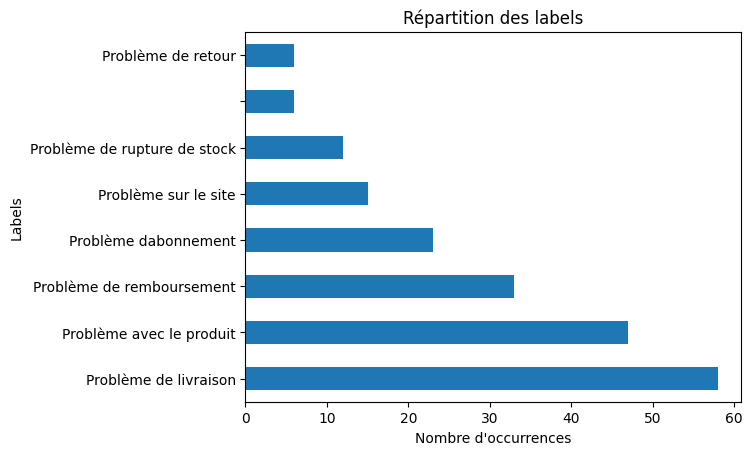

In [8]:
# Nombre d'occurrences de chaque label

import matplotlib.pyplot as plt

class_counts = supervised_df['chatgpt_label'].value_counts()
print(class_counts)

plt.figure()
class_counts.plot(kind='barh')
plt.title('Répartition des labels')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Labels')
plt.show()

Certains labels sont plus représentés que d'autres, ce qui peut biaiser l'apprentissage du modèle.

In [ ]:
# 3e méthode : classification basée sur la similarité
# Objectif = utiliser la similarité sémantique pour propager les labels du dataset labéliisé vers les commentaires similaires dans le dataset de travail.

# Génération d'embeddings pour chaque commentaire dans le dataset de travail (df) et le dataset labellisé (supervised_df)

!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

embeddings_df = model.encode(df[df['sentiment'] == 'negatif']['cleaned_lemma'].tolist(), convert_to_tensor=False)
embeddings_supervised_df = model.encode(supervised_df['review'].tolist(), convert_to_tensor=False)


In [ ]:
# Recherche des commentaires les plus similaires dans df

!pip install faiss-cpu

import faiss

embeddings_df = np.array(embeddings_df).astype('float32')
embeddings_supervised_df = np.array(embeddings_supervised_df).astype('float32')

# normalisation pour la similarité cosinus
embeddings_df = embeddings_df / np.linalg.norm(embeddings_df, axis=1, keepdims=True)
embeddings_supervised_df = embeddings_supervised_df / np.linalg.norm(embeddings_supervised_df, axis=1, keepdims=True)

dimension = embeddings_supervised_df.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings_supervised_df)

D, I = index.search(embeddings_df, k=10)


In [ ]:
# Affichage des 10 commentaires négatifs du dataset labélisé les plus proches

for idx, row in enumerate(embeddings_df[:10]):
    print(f"Commentaire (df) #{idx + 1}: {df[df['sentiment'] == 'negatif']['cleaned_lemma'].iloc[idx]}\n")

    print("Top 10 des commentaires les plus similaires (supervised_df):")
    for rank, (similarity, match_idx) in enumerate(zip(D[idx], I[idx]), start=1):
        print(f"{rank}. Similarité: {similarity:.2f}, Commentaire: {supervised_df['review'].iloc[match_idx]}")

    print("-" * 80 + "\n")


Commentaire (df) #1: colis commander mardi  fevrier   livraison  jeudi  mars  produit non recu   mars 23au prix  colis  amazon  incapable  chronopost pareilservic client  veule   patient  journée  plusle colis  introuvable   chronopost renvoyer  balle  amazonamazon vouloir   renvoyer   article   ca   semaine   attendre  colis

Top 10 des commentaires les plus similaires (supervised_df):
1. Similarité: 0.76, Commentaire: J’attendais une commande sur Amazon le 14 septembre 2022. C’était important, c’était la promesse de livraison, confirmée par mail le jour même. Je reçois en tout début d’après-midi un mail m’expliquant que le transporteur n’avait pu livrer, m’invitant à vérifier mon adresse. J’ai fait 500 commandes en quelques années à mon adresse mais bon… J’ai eu plusieurs conseillers clientèle et reçu plusieurs mails me confirmant la livraison ce jour du 14 septembre. La livraison n’a pas eu lieu. Aujourd’hui 15 septembre, j’apprends qu’il y a eu « un problème informatique ». Une exc

In [ ]:
# Propagation des labels

df['assigned_label'] = None

indices_negatifs = df[df['sentiment'] == 'negatif'].index

for idx, index_negatif in enumerate(indices_negatifs):
    most_similar_index = I[idx][0]
    assigned_label = supervised_df['chatgpt_label'].iloc[most_similar_index]

    df.at[index_negatif, 'assigned_label'] = assigned_label

df.head()

,commentaire,star,date,source,company,cleaned_words,cleaned_lemma,sentiment,year,assigned_label
0,"Colis commandé mardi 28 fevrier 23 , livraison le jeudi 02 mars 23 produit non recu au 7 mars 23Au prix du colis, amazon des incapables et chronopost pareilService client qui veule que je patiente une journée de plusLe colis est introuvable et meme chronopost renvoie la balle a amazonAmazon veut pas me renvoyé un autre article alors que ca fait une semaine que j'attend ce colis",1,2023-03-07,TrustPilot,Amazon,colis commandé mardi fevrier livraison jeudi mars produit non recu mars 23au prix colis amazon incapables chronopost pareilservice client veule patiente journée plusle colis introuvable chronopost renvoie balle amazonamazon veut renvoyé article ca semaine attend colis,colis commander mardi fevrier livraison jeudi mars produit non recu mars 23au prix colis amazon incapable chronopost pareilservic client veule patient journée plusle colis introuvable chronopost renvoyer balle amazonamazon vouloir renvoyer article ca semaine attendre colis,negatif,2023,"[""Problème de livraison""]"
1,Amazon avec sa politique de retour est la pire que j ai vu contrairement a d autre site marchand.Montre défectueuse rendu il y a 10 jours et toujours pas de remboursement ce sont des méthodes de voleurs et de voyous et au téléphone il n y a que des incompétents et personne n a la même version de jours de retourAmazon c est a fuir dernière fois que je commande chez eux la concurrence est plus professionnelle.,1,2023-03-07,TrustPilot,Amazon,amazon politique pire contrairement site marchand.montre défectueuse rendu jours remboursement méthodes voleurs voyous téléphone incompétents version jours retouramazon fuir dernière fois commande concurrence professionnelle,amazon politique pire contrairement site marchand.montr défectueux rendre jour remboursement méthode voleur voyou téléphone incompétent version jour retouramazon fuir dernier fois commande concurrence professionnel,negatif,2023,"[""Problème de livraison""]"
2,"Dieu sait que j'en connais des déboires avec les sites marchands. Amazon n'échappe pas à la règle, il m'arrive d'expérimenter quelques désagréments. CEPENDANT, je n'ai rien à redire sur le service client d'Amazon. Les agents sont vraiment tournés vers la satisfaction du client. Ca change des autres commerces. Etant Prime, les livraisons rapides et retours gratuits sont très appréciables. Les autres commerces devraient s'en inspirer !!!",4,2023-03-07,TrustPilot,Amazon,dieu connais déboires sites marchands amazon échappe règle arrive expérimenter désagréments rien redire service client amazon agents vraiment tournés satisfaction client ca change commerces prime livraisons rapides retours gratuits appréciables commerces devraient inspirer,dieu connaître déboire site marchand amazon échapper règle arriver expérimenter désagrément rien redire service client amazon agent vraiment tourner satisfaction client ca changer commerce prime livraison rapide retour gratuit appréciable commerce devoir inspirer,positif,2023,None
3,"Nul, preleve une commande que je n'ai jamais reçu et le service client laisse des blancs jusqu'à ce qu'on raccroche et ça sur plusieurs appel. Donc amazone ma volé Dernière commande pour moi passé chez eux, ça m'apprendras à vouloir acheter chez les americains",1,2023-03-07,TrustPilot,Amazon,preleve commande jamais reçu service client laisse blancs jusqu' raccroche appel amazone volé dernière commande passé apprendras vouloir acheter americains,prelev commande jamais recevoir service client laisse blanc jusque raccrocher appel amazone voler dernier commande passer apprendre vouloir acheter americain,negatif,2023,"[""Problème de livraison""]"
4,Colis soit disant livré mais jamais reçu donc perdu non remboursé et falsification du bon de livraison soit disant signé par mes soins (Signature en majuscule) MDR je ne signe jamais de documents en majuscule ils moquent de leurs clients je vais résilier mon aboment Amazon Prime et en fi

In [ ]:
# Validation croisée en utilisant le dataset supervisé

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(supervised_df['review'], supervised_df['chatgpt_label'], test_size=0.2, random_state=42)

embeddings_train = model.encode(X_train.tolist(), convert_to_tensor=False)
embeddings_test = model.encode(X_test.tolist(), convert_to_tensor=False)

index = faiss.IndexFlatIP(embeddings_train.shape[1])
index.add(embeddings_train.astype('float32'))

D, I = index.search(embeddings_test.astype('float32'), k=1)

y_pred = [y_train.iloc[i] for i in I.flatten()]

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy :", accuracy)

Accuracy : 0.45


La performance est relativement faible. Cela peut être dû au déséquilibre des classes (labels) entraînant le modèle à apprendre à reconnaître majoritairement la classe la plus fréquente au détriment des autres.
Nous allont tenter une autre architecture de modèle pour comparer les performances.

In [ ]:
# 4e méthode : classification par réseau de neurones

# Préparation des données pour le DNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(supervised_df['review'], supervised_df['chatgpt_label'], test_size=0.2, random_state=42)

all_labels = pd.concat([y_train, y_test])

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_embeddings = model.encode(X_train.tolist(), convert_to_tensor=False)
X_test_embeddings = model.encode(X_test.tolist(), convert_to_tensor=False)

scaler = StandardScaler()

X_train_embeddings_scaled = scaler.fit_transform(X_train_embeddings)
X_test_embeddings_scaled = scaler.transform(X_test_embeddings)


In [ ]:
# Classification avec DNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf

model_nn = Sequential()
model_nn.add(Dense(32, activation='relu', input_shape=(X_train_embeddings_scaled.shape[1],)))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_nn.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model_nn.fit(X_train_embeddings_scaled, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30
4/4 [==============================] - 1s 71ms/step - loss: 2.9029 - accuracy: 0.0938 - val_loss: 2.1170 - val_accuracy: 0.2500
Epoch 2/30
4/4 [==============================] - 0s 14ms/step - loss: 2.4197 - accuracy: 0.2031 - val_loss: 1.9660 - val_accuracy: 0.2500
Epoch 3/30
4/4 [==============================] - 0s 14ms/step - loss: 2.2580 - accuracy: 0.2422 - val_loss: 1.8557 - val_accuracy: 0.3750
Epoch 4/30
4/4 [==============================] - 0s 14ms/step - loss: 2.0108 - accuracy: 0.3359 - val_loss: 1.7635 - val_accuracy: 0.4375
Epoch 5/30
4/4 [==============================] - 0s 13ms/step - loss: 1.7172 - accuracy: 0.4062 - val_loss: 1.6943 - val_accuracy: 0.4688
Epoch 6/30
4/4 [==============================] - 0s 13ms/step - loss: 1.7085 - accuracy: 0.4297 - val_loss: 1.6392 - val_accuracy: 0.5000
Epoch 7/30
4/4 [==============================] - 0s 14ms/step - loss: 1.5082 - accuracy: 0.5156 - val_loss: 1.5962 - val_accuracy: 0.5312
Epoch 8/30
4/4 [===========

Le modèle DNN atteint une accuracy d'entraînement de 87.5%, ce qui est supérieur aux 45% de l'approche basée sur la similarité.

L'accuracy de validation de 53.12% est également meilleure que celle de 45%, mais elle est bien inférieure à l'accuracy d'entraînement, ce qui indique un surapprentissage. Le modèle DNN performe bien sur les données d'entraînement mais a du mal à généraliser.

In [ ]:
# Test avec commentaires df

embeddings_df = model.encode(df[df['sentiment'] == 'negatif']['cleaned_lemma'].tolist(), convert_to_tensor=False)

embeddings_df_scaled = scaler.transform(embeddings_df)

predicted_labels_encoded = model_nn.predict(embeddings_df_scaled)
predicted_labels = np.argmax(predicted_labels_encoded, axis=1)

predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

for idx, index in enumerate(indices_negatifs):
    df.at[index, 'predicted_label'] = predicted_labels_decoded[idx]

df.head()


868/868 [==============================] - 1s 1ms/step


,commentaire,star,date,source,company,cleaned_words,cleaned_lemma,sentiment,year,assigned_label,predicted_label
0,"Colis commandé mardi 28 fevrier 23 , livraison le jeudi 02 mars 23 produit non recu au 7 mars 23Au prix du colis, amazon des incapables et chronopost pareilService client qui veule que je patiente une journée de plusLe colis est introuvable et meme chronopost renvoie la balle a amazonAmazon veut pas me renvoyé un autre article alors que ca fait une semaine que j'attend ce colis",1,2023-03-07,TrustPilot,Amazon,colis commandé mardi fevrier livraison jeudi mars produit non recu mars 23au prix colis amazon incapables chronopost pareilservice client veule patiente journée plusle colis introuvable chronopost renvoie balle amazonamazon veut renvoyé article ca semaine attend colis,colis commander mardi fevrier livraison jeudi mars produit non recu mars 23au prix colis amazon incapable chronopost pareilservic client veule patient journée plusle colis introuvable chronopost renvoyer balle amazonamazon vouloir renvoyer article ca semaine attendre colis,negatif,2023,"[""Problème de livraison""]","[""Problème de livraison""]"
1,Amazon avec sa politique de retour est la pire que j ai vu contrairement a d autre site marchand.Montre défectueuse rendu il y a 10 jours et toujours pas de remboursement ce sont des méthodes de voleurs et de voyous et au téléphone il n y a que des incompétents et personne n a la même version de jours de retourAmazon c est a fuir dernière fois que je commande chez eux la concurrence est plus professionnelle.,1,2023-03-07,TrustPilot,Amazon,amazon politique pire contrairement site marchand.montre défectueuse rendu jours remboursement méthodes voleurs voyous téléphone incompétents version jours retouramazon fuir dernière fois commande concurrence professionnelle,amazon politique pire contrairement site marchand.montr défectueux rendre jour remboursement méthode voleur voyou téléphone incompétent version jour retouramazon fuir dernier fois commande concurrence professionnel,negatif,2023,"[""Problème de livraison""]","[""Problème de remboursement""]"
2,"Dieu sait que j'en connais des déboires avec les sites marchands. Amazon n'échappe pas à la règle, il m'arrive d'expérimenter quelques désagréments. CEPENDANT, je n'ai rien à redire sur le service client d'Amazon. Les agents sont vraiment tournés vers la satisfaction du client. Ca change des autres commerces. Etant Prime, les livraisons rapides et retours gratuits sont très appréciables. Les autres commerces devraient s'en inspirer !!!",4,2023-03-07,TrustPilot,Amazon,dieu connais déboires sites marchands amazon échappe règle arrive expérimenter désagréments rien redire service client amazon agents vraiment tournés satisfaction client ca change commerces prime livraisons rapides retours gratuits appréciables commerces devraient inspirer,dieu connaître déboire site marchand amazon échapper règle arriver expérimenter désagrément rien redire service client amazon agent vraiment tourner satisfaction client ca changer commerce prime livraison rapide retour gratuit appréciable commerce devoir inspirer,positif,2023,None,NaN
3,"Nul, preleve une commande que je n'ai jamais reçu et le service client laisse des blancs jusqu'à ce qu'on raccroche et ça sur plusieurs appel. Donc amazone ma volé Dernière commande pour moi passé chez eux, ça m'apprendras à vouloir acheter chez les americains",1,2023-03-07,TrustPilot,Amazon,preleve commande jamais reçu service client laisse blancs jusqu' raccroche appel amazone volé dernière commande passé apprendras vouloir acheter americains,prelev commande jamais recevoir service client laisse blanc jusque raccrocher appel amazone voler dernier commande passer apprendre vouloir acheter americain,negatif,2023,"[""Problème de livraison""]","[""Problème d'abonnement""]"
4,Colis soit disant livré mais jamais reçu donc perdu non remboursé et falsification du bon de livraison soit disant signé par mes soins (Signature en majuscule) MDR je ne sign

Dans la prolongation des méthode 3 et 4, nous allons maintenant finetuner un Sentence Bert afin de voir si le modèle améliore la classification par similartié et avec un DNN.